In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
mpl.style.use('bmh')

In [2]:
import numpy as np

import torch
import random
import math
import json

from tqdm import tqdm_notebook
from boltons.iterutils import pairwise
from scipy.stats import kendalltau
from itertools import permutations

from sent_order.models.kt_regression import SentenceEncoder, Regressor, Corpus
from sent_order.perms import sample_uniform_perms

In [3]:
sent_encoder = torch.load(
    '../../data/models/new/kt-reg/sent_encoder.237.bin',
    map_location={'cuda:0': 'cpu'},
)

In [4]:
regressor = torch.load(
    '../../data/models/new/kt-reg/regressor.237.bin',
    map_location={'cuda:0': 'cpu'},
)

In [5]:
train = Corpus('../../data/dev.json/', 10000)

100%|██████████| 10000/10000 [00:01<00:00, 7305.94it/s]


In [6]:
grafs = [g for g in train.grafs if len(g.sentences) == 7]

In [7]:
len(grafs)

948

In [36]:
graf = random.choice(grafs)

In [37]:
[' '.join(s.tokens) for s in graf.sentences]

['The goal of imitation learning is for an apprentice to learn how to behave in a stochastic environment by observing a mentor demonstrating the correct behavior .',
 'Accurate prior knowledge about the correct behavior can reduce the need for demonstrations from the mentor .',
 "We present a novel approach to encoding prior knowledge about the correct behavior , where we assume that this prior knowledge takes the form of a Markov Decision Process ( MDP ) that is used by the apprentice as a rough and imperfect model of the mentor 's behavior .",
 'Specifically , taking a Bayesian approach , we treat the value of a policy in this modeling MDP as the log prior probability of the policy .',
 "In other words , we assume a priori that the mentor 's behavior is likely to be a high value policy in the modeling MDP , though quite possibly different from the optimal policy .",
 'We describe an efficient algorithm that , given a modeling MDP and a set of demonstrations by a mentor , provably con

In [38]:
sents = sent_encoder(graf.sentence_variables())

In [39]:
sents

Variable containing:
-3.7843e-03  2.8414e-02 -9.8361e-03  ...   1.9698e-03 -7.1523e-01 -1.7004e-03
-7.5278e-04  3.3103e-03 -7.9406e-05  ...   1.5030e-04  3.0470e-01  6.0801e-07
-2.2022e-03  1.0981e-02 -6.9851e-05  ...   8.1779e-05 -1.5903e-01  6.9663e-07
                ...                   ⋱                   ...                
-4.4153e-04 -1.4286e-02 -3.5535e-05  ...  -2.6418e-04  6.7305e-02 -1.1454e-03
-1.8732e-03 -2.5051e-01  3.1732e-05  ...   6.5268e-05 -2.5525e-01 -4.0534e-06
 7.3676e-05  1.2915e-04 -2.8873e-04  ...   1.9953e-04  2.5607e-02 -2.6962e-05
[torch.FloatTensor of size 7x1000]

In [40]:
perms = list(permutations(range(7)))

In [41]:
x = []
kts = []
for perm in tqdm_notebook(perms):
    
    sort = torch.LongTensor(perm)
    x.append(sents[sort])
    
    kt = kendalltau(perm, range(7)).correlation
    kts.append(kt)

HBox(children=(IntProgress(value=0, max=5040), HTML(value='')))

In [42]:
x = torch.stack(x)
y = regressor(x)

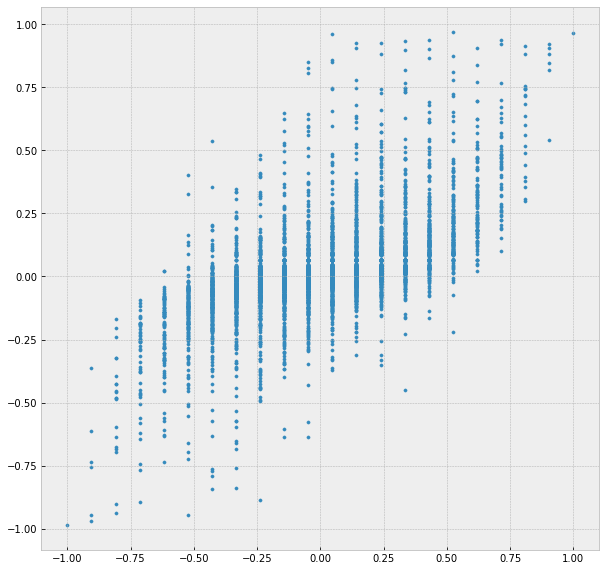

In [43]:
plt.figure(figsize=(10,10))
plt.scatter(kts, y.data.tolist(), s=10)

(array([   1.,    0.,    0.,    0.,    6.,    0.,    0.,    0.,    0.,
          20.,    0.,    0.,    0.,    0.,   49.,    0.,    0.,    0.,
           0.,   98.,    0.,    0.,    0.,  169.,    0.,    0.,    0.,
           0.,  259.,    0.,    0.,    0.,    0.,  359.,    0.,    0.,
           0.,    0.,  455.,    0.,    0.,    0.,  531.,    0.,    0.,
           0.,    0.,  573.,    0.,    0.,    0.,    0.,  573.,    0.,
           0.,    0.,    0.,  531.,    0.,    0.,    0.,  455.,    0.,
           0.,    0.,    0.,  359.,    0.,    0.,    0.,    0.,  259.,
           0.,    0.,    0.,    0.,  169.,    0.,    0.,    0.,   98.,
           0.,    0.,    0.,    0.,   49.,    0.,    0.,    0.,    0.,
          20.,    0.,    0.,    0.,    0.,    6.,    0.,    0.,    0.,    1.]),
 array([-1.  , -0.98, -0.96, -0.94, -0.92, -0.9 , -0.88, -0.86, -0.84,
        -0.82, -0.8 , -0.78, -0.76, -0.74, -0.72, -0.7 , -0.68, -0.66,
        -0.64, -0.62, -0.6 , -0.58, -0.56, -0.54, -0.52, -0.5 , -0.4

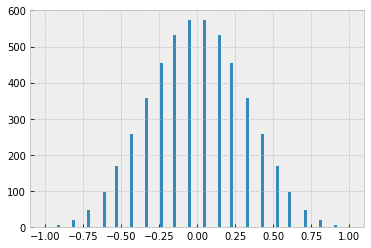

In [34]:
plt.hist(kts, bins=100)

(array([   1.,    1.,    0.,    3.,    1.,    1.,    3.,    2.,    1.,
           1.,    2.,    0.,    1.,    1.,    2.,    1.,    3.,    0.,
           4.,    4.,    3.,    2.,    3.,    4.,    3.,    3.,    6.,
          11.,    5.,   10.,   18.,   10.,   17.,   33.,   21.,   29.,
          35.,   39.,   51.,   61.,   56.,   62.,   86.,   90.,  125.,
         149.,  215.,  321.,  399.,  563.,  659.,  460.,  122.,  335.,
         161.,  115.,   96.,   69.,   52.,   62.,   55.,   46.,   23.,
          32.,   26.,   31.,   33.,   23.,   21.,   10.,   16.,   15.,
           9.,   13.,    9.,    8.,    6.,    5.,    5.,    2.,    4.,
           4.,    6.,    5.,    1.,    3.,    4.,    5.,    2.,    3.,
           4.,    0.,    2.,    4.,    0.,    1.,    3.,    3.,    4.,    1.]),
 array([-0.95125008, -0.93214816, -0.91304624, -0.89394433, -0.87484241,
        -0.8557405 , -0.83663858, -0.81753666, -0.79843475, -0.77933283,
        -0.76023092, -0.741129  , -0.72202708, -0.70292517, -0.6

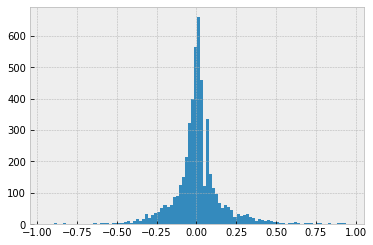

In [35]:
plt.hist(y.data.tolist(), bins=100)